# Accessing Data through ORNL DAAC Web Services
## Exploring Forest Disturbance Caused by Bark Beetles at Fairview Curve, Rocky Mountain National Park

*Author: ORNL DAAC*  
*Date: April 21, 2019*  
*Contact for ORNL DAAC: uso@daac.ornl.gov*  

**Keywords:** Web service, Python, Open Geospatial Consortium (OGC), REST API, MODIS, Daymet, Spatial Data Access Tool (SDAT)


## Web Services at the ORNL DAAC 
The [ORNL DAAC](https://daac.ornl.gov/) (Oak Ridge National Laboratory Distributed Active Archive Center) for Biogeochemical Dynamics is a National Aeronautics and Space Administration (NASA) Earth Observing System Data and Information System (EOSDIS) data center managed by the Earth Science Data and Information System  (ESDIS) Project.

The ORNL DAAC offers many [tools and services](https://daac.ornl.gov/tools/) for visualization and access to data, which will be demonstrated in this tutorial.

The Web services used in this tutorial include:
* [MODIS Web Service](https://modis.ornl.gov/data/modis_webservice.html), a [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) Web service, to access [MODIS Land Products](https://modis.ornl.gov/documentation.html)
* [Daymet Single Pixel Tool](https://daymet.ornl.gov/web_services.html), a [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) web service to access daily weather parameters offered in the [Daymet data product](https://daymet.ornl.gov/) at a single geographic point
* [Spatial Data Access Tools (SDAT)](https://webmap.ornl.gov/ogc) offers [OGC](http://www.opengeospatial.org/)-based [REST](https://en.wikipedia.org/wiki/Representational_state_transfer) Web services to visualize and download spatial data in various user-selected spatial/temporal extents and formats. The SDAT is a general-purpose Web application. It contains 187 archived data products (as of April 2019) in many science disciplines, including agriculture, biosphere, climate, land surface, etc.
	* [Web Map Service (WMS)](https://en.wikipedia.org/wiki/Web_Map_Service): Get maps (i.e., visualization) of geospatial data from a remote server
	* [Web Coverage Service (WCS)](https://en.wikipedia.org/wiki/Web_Coverage_Service): Download geospatial data from a remote server

With both OGC WMS and WCS, you can customize maps for the data you need. For example, you can choose the spatial region, the data and map format (e.g., GeoTIFF for WCS; PNG for WMS), the coordinate reference system or projection, and the resolution.

## Overview
In this tutorial, we will use several Web services to access and combine datasets near Fairview Curve at Rocky Mountain National Park in Colorado (latitude = 40.399391, longitude = -105.835901) to investigate tree mortality owing to bark beetle infestation from 2006-2010.

![Image_Bark_Beetle_Farview_Curve](https://www.nps.gov/romo/learn/nature/images/ForestHealth_MPB_Comparison_688x300.jpg)


The photos above were taken in late summer in 2005 (left) and 2009 (right), and illustrate the effects of bark beetle infestation. One way to quantitatively access the impacts of bark beetles on tree mortality is to use a vegetation index, which indicated the health of vegetation.

### Data Products
Data products used in theis tutorial include:
* [MOD13Q1](https://lpdaac.usgs.gov/products/mod13q1v006/): MODIS (Collection 6) 16 day Enhanced Vegetation Index (EVI) at 250 m spatial resolution.
	* Accessed through MODIS Web service
* [Daymet](https://daymet.ornl.gov/overview): Daily total precipitation and daily maximum/minimum temperature at 1 km spatial resolution.
	* Accessed through Daymet single pixel Web service
* [Tree Mortality from Bark Beetles](https://doi.org/10.3334/ORNLDAAC/1512): yearly total tree motality (in Mg C km2) at 1 km Resolution in the western USA for 2003-2012
	* Accessed through SDAT OGC WMS and WCS

### Prerequisites
Python 2.7 or later and modules: numpy, pandas, matplotlib, urllib, zeep, owslib, datetime, owslib, pycurl, modisViirsClient

We will use [modisViirsClient](https://github.com/tquaife/modisViirsClient) to call ORNL DAAC's MODIS REST service. The repository is cloned into this one to preserve the code in its current state. If you would like to use the most up-to-date version of the code, you can pull the latest updates from git:
```{shell}
cd modisViirsClient  # make sure you are inside the subdirectory for the modisViirsClient repo
git pull                    # pull updates via git
``` 

## Tutorial
Let's import some python modules to be used in this Jupyter notebook.

In [1]:
%matplotlib inline
# above generates plots in line within this page

import numpy as np # numpy module for array operations
import pandas as pd # pandas module for tabular data
import matplotlib.pyplot as plt # matplotlib module for plotting
import datetime as dt # datetime module for converting dates
import json  # json lets you produce REST output in readable format
import urllib # urllib allows you to access legend images from SDAT
from owslib.wms import WebMapService # OWSlib module to access WMS services from SDAT
from owslib.wcs import WebCoverageService  # OWSlib module to access WCS services from SDAT
from IPython.display import Image # Displaying image

# import modisViirsClient
import sys
sys.path.insert(0, 'modisViirsClient')
from modisViirsClient import *

print('Done!')

Done!


Then define the location of the study.

In [2]:
# Fairview Curve, Rocky Mountain National Park, Colorado
latitude = 40.399391
longitude = -105.835901

# Deep Creek Ridge in Central Idaho 
# latitude = 45.0949 
# longitude = -114.1086

print('Latitude: ' + str(latitude))
print('Longitude: ' + str(longitude))

Latitude: 40.399391
Longitude: -105.835901


### 1. Download Weather Data using the Daymet Single Pixel Tool

The Daymet Single Pixel Tool requires a url to be formated like: 
> https://<i></i>daymet.ornl.gov/data/send/saveData?lat=**lat**&lon=**lon**&measuredParams=**params**&year=**years**

where **lat** and **lon** are the latitude and longitude values in decimal degrees, **params** is a comma-separated list of parameters (tmax, tmin, dayl, prcp, srad, swe, vp) and **years** is a comma-separated list of years.

Here, we will download daily precipitation data (**prcp**), daily minimum temperature data (**tmin**), and daily maximum temperature data (**tmax**) from 2003-2011 at our location of interest.

In [3]:
# list of years to retrieve data
yrs = "2003,2004,2005,2006,2007,2008,2009,2010,2011"

# Daymet URL. It is important that the URL is structured correctly
daymeturl = "https://daymet.ornl.gov/data/send/saveData?lat={lat}&lon={lon}&measuredParams=prcp,tmax,tmin&year={year}"

# read daymet_file, first 6 lines are headers
daymetdf = pd.read_csv(daymeturl.format(lat=latitude, lon=longitude, year=yrs), header=6)

# convert year and day of year into python datetime
daymetdf.index = pd.to_datetime(daymetdf.year.astype(int).astype(str) + '-' + daymetdf.yday.astype(int).astype(str), format="%Y-%j")

# preview the first five rows
print('Firt 5 rows of daymetdf:')
print(daymetdf[:5])

# retrieve Daymet data in 1981-2010 to calculate 30-yr normal
yrs = "1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010"
daymetdf_30yrs = pd.read_csv(daymeturl.format(lat=latitude, lon=longitude, year=yrs), header=6)
daymetdf_30yrs.index = pd.to_datetime(daymetdf_30yrs.year.astype(int).astype(str) + '-' + daymetdf_30yrs.yday.astype(int).astype(str), format="%Y-%j")

# preview the first five rows
print('\nFirt 5 rows of daymetdf_30yrs:')
print(daymetdf_30yrs[:5])

Firt 5 rows of daymetdf:
              year  yday  prcp (mm/day)  tmax (deg c)  tmin (deg c)
2003-01-01  2003.0   1.0            6.0          -5.0         -15.0
2003-01-02  2003.0   2.0            3.0          -4.5         -16.0
2003-01-03  2003.0   3.0            3.0          -0.5          -7.0
2003-01-04  2003.0   4.0            3.0          -0.5          -5.5
2003-01-05  2003.0   5.0            0.0          -1.5          -7.0

Firt 5 rows of daymetdf_30yrs:
              year  yday  prcp (mm/day)  tmax (deg c)  tmin (deg c)
1981-01-01  1981.0   1.0            0.0           5.0         -13.5
1981-01-02  1981.0   2.0            0.0           6.0         -10.5
1981-01-03  1981.0   3.0            0.0           3.5         -11.0
1981-01-04  1981.0   4.0            0.0           3.5         -10.5
1981-01-05  1981.0   5.0            0.0           2.5         -12.0


Now, rename the columns into something shorter, create annual precipitation, and plot the results.

Plots:


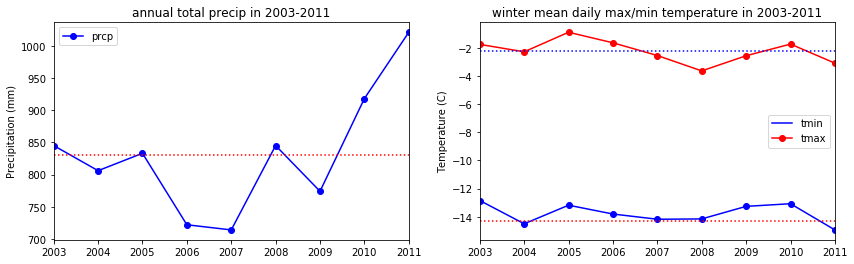

In [4]:
# rename columns to make them shorter and no whitespace
daymetdf=daymetdf.rename(columns = {'prcp (mm/day)':'prcp', 'tmax (deg c)':'tmax', 'tmin (deg c)':'tmin'})
daymetdf_30yrs=daymetdf_30yrs.rename(columns = {'prcp (mm/day)':'prcp', 'tmax (deg c)':'tmax', 'tmin (deg c)':'tmin'})

# compute annual total precipitation
daymetdf_ann = daymetdf.groupby(pd.Grouper(freq='1Y')).aggregate(np.sum)
daymetdf_30yrs_ann = daymetdf_30yrs.groupby(pd.Grouper(freq='1Y')).aggregate(np.sum)

# compute monthly mean temperature in winter season (Dec, Jan, and Feb)
daymetdf_mon = daymetdf.groupby(pd.Grouper(freq='1M')).aggregate(np.mean)
daymetdf_wtr = daymetdf_mon[(daymetdf_mon['yday']<59) | (daymetdf_mon['yday']>334)]
daymetdf_wtr = daymetdf_wtr.groupby(pd.Grouper(freq='1Y')).aggregate(np.mean)

daymetdf_30yrs_mon = daymetdf_30yrs.groupby(pd.Grouper(freq='1M')).aggregate(np.mean)
daymetdf_30yrs_wtr = daymetdf_30yrs_mon[(daymetdf_30yrs_mon['yday']<59) | (daymetdf_30yrs_mon['yday']>334)]
daymetdf_30yrs_wtr = daymetdf_30yrs_wtr.groupby(pd.Grouper(freq='1Y')).aggregate(np.mean)

# make two plots
# 1st plot shows time series of annual total precip in 2003-2011, comparing with 30-yr normal
# 2nd plot shows time series of winter mean daily max/min temperature in 2003-2011, comparing with 30-yr winter normal
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

daymetdf_ann.prcp.plot(legend=True, marker='o', style='b', ax=ax1)
ax1.axhline(y=daymetdf_ann.prcp.mean(), color='r', linestyle=':')
ax1.set(title='annual total precip in 2003-2011')
ax1.set(ylabel='Precipitation (mm)')

daymetdf_wtr.tmin.plot(legend=True, marker='o', style='b', ax=ax2)
daymetdf_wtr.tmax.plot(legend=True, marker='o', style='r', ax=ax2)
ax2.axhline(y=daymetdf_30yrs_wtr.tmin.mean(), color='r', linestyle=':')
ax2.axhline(y=daymetdf_30yrs_wtr.tmax.mean(), color='b', linestyle=':')
ax2.set(title='winter mean daily max/min temperature in 2003-2011')
ax2.set(ylabel='Temperature (C)')

print('Plots:')

In the chart above, we can see that years 2004-2009 were dry (received less precipitation) compared with the 30-yr normal. During a drought period, the water-stressed trees are more susceptible to the bark beetles. Also, daily minimum temperature during winter time in years 2004-2009 was higher than normal (calculated from 1981-2010 Daymet data). Warmer winters favor the growth of bark beetle infestations.

### 2. Download Vegetation Index with the MODIS Web Service

Now, we will use ORNL DAAC's MODIS Web service to download the MODIS Vegetation Index (EVI from [MOD13Q1](https://doi.org/10.5067/modis/mod13q1.006)). The MODIS product MOD13Q1 is a gridded product with a time frequency of 16 days and a spatial resolution of 250 m.

We will use  [modisViirsClient](https://github.com/tquaife/modisViirsClient) to access the MODIS Web service, and then print the bands available for product MOD13Q1. 

In [5]:
product = 'MOD13Q1' # MODIS Terra vegetation index

response=modViirRequest(product)
m=parseModViirJSON(response)
print (json.dumps(m.bands, indent=2))

[
  {
    "units": "bit field", 
    "band": "250m_16_days_VI_Quality", 
    "fill_value": "-1", 
    "description": "VI quality indicators", 
    "valid_range": "0 to 65534"
  }, 
  {
    "scale_factor": "0.0001", 
    "description": "Surface Reflectance Band 3", 
    "fill_value": "-1000", 
    "valid_range": "0 to 10000", 
    "band": "250m_16_days_blue_reflectance", 
    "units": "reflectance", 
    "add_offset": "0"
  }, 
  {
    "units": "rank", 
    "band": "250m_16_days_pixel_reliability", 
    "fill_value": "-1", 
    "description": "Quality reliability of VI pixel", 
    "valid_range": "0 to 3"
  }, 
  {
    "scale_factor": "0.0001", 
    "description": "Surface Reflectance Band 2", 
    "fill_value": "-1000", 
    "valid_range": "0 to 10000", 
    "band": "250m_16_days_NIR_reflectance", 
    "units": "reflectance", 
    "add_offset": "0"
  }, 
  {
    "scale_factor": "0.0001", 
    "description": "Surface Reflectance Band 7", 
    "fill_value": "-1000", 
    "valid_range": "

The vegetation index we are interested is '250m_16_days_EVI' which contains metadata elements (e.g., scale_factor). Let's retrieve the `scale_factor` value and assign it to variable "scale." 

In [6]:
band = '250m_16_days_EVI' # EVI band

evi_band = [item for item in m.bands if item['band'] == band]
scale = float(evi_band[0]['scale_factor'])
print("Scale factor: " + str(scale))

Scale factor: 0.0001


Also note the '250m_16_days_VI_Quality' band which contains quality information about the band. For the sake of simplicity, we will not apply quality filters in this tutorial. Read more about the quality band [here](https://lpdaac.usgs.gov/documents/103/MOD13_User_Guide_V6.pdf). 

We will now download MODIS EVI data from the start of 2003 to the end of 2012. This might take a while to run, so sit back and relax while it finishes downloading the data. Once we download the data, we apply the scale factor and arrange data into a Pandas dataframe.

In [7]:
#start and end times
startdate=dt.datetime(year=2003,month=1,day=1)
enddate=dt.datetime(year=2012,month=12,day=31)

# count how long it takes to download all data
print('Start: ' + str(dt.datetime.now()))

# download and parse data
response=modViirRequest(product,band=band,latitude=latitude,longitude=longitude,start_date=startdate, end_date=enddate)
modEvi=parseModViirJSON(response)

# apply scale factor and put data into a Pandas dataframe
evidf = pd.DataFrame(data=scale*modEvi.data[band][:,0,0], index=modEvi.dates, columns=['evi'])

print('End: ' + str(dt.datetime.now()))

Start: 2019-05-17 15:52:33.377000


Exception: Sever returned status code: 500
{
    "status": 500, 
    "type": "about:blank", 
    "detail": "The server encountered an internal error and was unable to complete your request.  Either the server is overloaded or there is an error in the application.", 
    "title": "Internal Server Error"
}

Save the Pandas dataframe as a CSV file so that we don't have to download the data again.

In [ ]:
evifile = 'sample_data/modis_evi_fairview_curve.csv'
evidf.to_csv(evifile, header=True)

To save time in this demo, instead of dynamically retrieving data from MODIS Web service, simply load data from the saved CSV file.

In [ ]:
evidf = pd.read_csv('https://www.dropbox.com/s/1whpd0qg1yptqix/modis_evi_fairview_curve.csv?dl=1', index_col=0, parse_dates=True)
evidf[:5]

Let's compute and plot the annual mean EVI values.

In [ ]:
eviyr = evidf.groupby(pd.Grouper(freq='1Y')).aggregate(np.mean)

# plot
ax = eviyr.plot(marker='o')
ax.set(ylabel='EVI')
ax.set(title='Annual Mean EVI (2003-2012)')

print('Plot: ')

The trend of the annual mean EVI values decreased significantly from 2007 to 2011 owing to tree mortality caused by bark beetles. The recovery started in 2012.

### 3. Download Tree Mortality from Bark Beetles with SDAT Web Service

We will use the [Tree Mortality from Fires and Bark Beetles at 1-km Resolution, Western USA, 2003-2012](https://doi.org/10.3334/ORNLDAAC/1512) dataset. This dataset provides annual estimates of tree mortality (as amount of aboveground carbon in the trees killed) due to fires and bark beetles from 2003 to 2012 on forestland in the continental western United States. The data is also available via [SDAT](https://webmap.ornl.gov/ogc/dataset.jsp?ds_id=1512.). 

If you look up the URLs of each granules, you will notice that the bark beetle data from 2003-2012 have 'dg_id' of '1512_1', '1512_3', '1512_5',...,'1512_17', '1512_19'. These are the layer names we will need when accessing the SDAT service.

Let's first connect to the ORNL DAAC WMS and retrieve its Capabilities document.

In [ ]:
sdatwms = WebMapService('https://webmap.ornl.gov/ogcbroker/wms')
print(str(len(sdatwms.contents)) + ' layers found from ' + sdatwms.identification.title)

List WMS layers that belong to dataset number 1512: Tree Mortality from Fires and Bark Beetles at 1-km Resolution, Western USA, 2003-2012.

In [ ]:
# define a filter function to find layers whose name start with '1512_'
def myFilter(x):
  if x.startswith('1512_'):
    return True
  else:
    return False

# filter layers
myLayers = filter(myFilter, sdatwms.contents)
for l in myLayers:
  print(sdatwms[l])

Print out some metadata associated with layer 1512_1: Tree Mortality from Bark Beetles in the Western USA 2003.

In [ ]:
print('Layer:')
print(sdatwms['1512_1'].title)
print('Bounding Box:')
print(sdatwms['1512_1'].boundingBox)
print('Bounding Box (WGS84):')
print(sdatwms['1512_1'].boundingBoxWGS84)

Then check what methods and format options are available for the WMS.

In [ ]:
[op.name for op in sdatwms.operations]
sdatwms.getOperationByName('GetMap').formatOptions

We will use the WMS "GetMap" operation to download the images in PNG format for years 2003-2011.

In [ ]:
# specify x/y spatial resolution in decimal degrees
resx = 0.010 
resy = 0.010

# The date range is 2003-2011
mortDates = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011] 

# odd numbered array starting from 1 to 17
odd_i = range(1, 18, 2)
for i, j in enumerate(odd_i):
    layername = '1512_' + str(j)
    img = sdatwms.getmap(layers=[layername],
                     srs='EPSG:4326', # WGS 84
                     bbox=(longitude-resx,latitude-resy,longitude+resx,latitude+resy), 
                     size=(100, 100), 
                     format='image/png', 
                     transparent=True)
    print(mortDates[i])
    display(Image(img.read()))

In the above images, higher tree mortality is displayed in darker red and no mortality in green. Mortality peaked between 2008 and 2009.

We need a legend for the maps.

In [ ]:
legend_url = sdatwms['1512_1'].styles['default']['legend']
urllib.urlretrieve(legend_url, 'sample_data/avhrr_legend.png')
display(Image('sample_data/avhrr_legend.png'))

To retrieve the tree mortality rates, we use SDAT's WCS. Then we plots the results.

In [ ]:
sdatwcs = WebCoverageService('https://webmap.ornl.gov/ogcbroker/wcs')
mort = [] # array to store mortality values (Mg C km-2)

for i,j in enumerate(odd_i):
    layername = '1512_' + str(j)
    mortality = sdatwcs.getCoverage(identifier=layername,
                           bbox=(longitude-resx,latitude-resy,longitude+resx,latitude+resy),
                           crs='EPSG:4326',
                           format='XYZ_FLOAT32',
                           interpolation='NEAREST',
                           resx=resx,
                           resy=resy)
    
    # output from above is in bytes; lets convert to string
    mortOut = mortality.read().decode("utf-8")
    mortValue = []
    
    # loop through the output and store mortality values
    for k, lines in enumerate(mortOut.splitlines()):
        if k > 0: # skipping the header line
            mortValue.append(int(lines.split(',')[2]))
    
    # mean mortality (Mg C km-2)
    mort.append(np.mean(mortValue))

print('Done!')

mortdf = pd.DataFrame(data=mort, index=mortDates, columns=['mortality'])

# print the tree mortality due to bark beetle
print(mortdf)

# plot it
mortdf.plot(marker='o')
plt.ylabel('Tree Mortality (Mg C km-2)')

### 4. Summary
The bark beetle infestation is often triggered by drought, with beetle activity becoming detectable within a year or two. As soon as the tree recovers from drought, the beetle [populations collapse and tree mortality diminishes](https://www.fs.usda.gov/detail/boise/news-events/?cid=STELPRD3841444). In this tutorial, we demonstrated basic methods to access data from three different Web services hosted at the ORNL DAAC. Now, can you put together the three datasets we just downloaded (vegetation index from MODIS, precipitation from Daymet, and tree mortality from an archived dataset) and draw conclusions from them.
